In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor

# set random seed for test
np.random.seed(42)

# load the data
boston = load_boston()
data_train, data_eval, target_train, target_eval = train_test_split(
    boston['data'], boston['target'], test_size=0.3, random_state=42)

def compute_prediction_interval(model, data_eval, percentile=95):
    decision_tree_list = model.estimators_
    lower_bound = (100 - percentile) / 2.
    upper_bound = 100 - lower_bound
    # this is the matrix of each predictions for each trees
    decision_tree_prediction_matrix = [_compute_prediction_of_each_tree(decision_tree_list, data_eval[i]) for i in
                                       range(len(data_eval))]
    lower_bound_prediction_list = [np.percentile(prediction_list, lower_bound) for prediction_list in
                                   decision_tree_prediction_matrix]
    upper_bound_prediction_list = [np.percentile(prediction_list, upper_bound) for prediction_list in
                                   decision_tree_prediction_matrix]
    return lower_bound_prediction_list, upper_bound_prediction_list


def _compute_prediction_of_each_tree(decision_tree_list, row):
    # reshaping is mandatory to avoid scikit warning
    reshaped_row = row.reshape(1, -1)
    return [decision_tree.predict(reshaped_row)[0] for decision_tree in decision_tree_list]


def test_90_percentile_prediction_interval_has_90_percent_of_ground_truth_inside_the_interval(min_samples_leaf=1):
    # Given
    boston = load_boston()
    data_train, data_eval, target_train, target_eval = train_test_split(
        boston['data'], boston['target'], test_size=0.3, random_state=42)
    rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, min_samples_leaf=min_samples_leaf)
    rf.fit(data_train, target_train)

    # When
    lower_error_list, upper_error_list = compute_prediction_interval(rf, data_eval, percentile=90)

    # Then
    ground_truth_inside_interval = 0
    for i, target_value in enumerate(target_eval):
        if lower_error_list[i] <= target_value <= upper_error_list[i]:
            ground_truth_inside_interval += 1
    ground_truth_inside_interval_percentage = ground_truth_inside_interval / float(len(target_eval))
    # check that we have roughly 90% of ground truth value inside the computed interval
    return ground_truth_inside_interval_percentage

In [12]:
test_90_percentile_prediction_interval_has_90_percent_of_ground_truth_inside_the_interval()

0.9013157894736842

In [3]:
test_90_percentile_prediction_interval_has_90_percent_of_ground_truth_inside_the_interval(min_samples_leaf=40)

0.5526315789473685

### On a vérifié qu'en ne construisant pas des arbres à feuilles pures, la variance de la distribution des prédictions diminue. Ainsi les intervalles de confiance diminuent aussi.

In [4]:
import matplotlib.pyplot as plt


def plot_eval_prediction_interval(target_eval, prediction, lower_error_list, upper_error_list, figsize=(10, 7)):
    x = range(len(prediction))
    permutation_sorted_ground_truth = target_eval.argsort()
    y = target_eval[permutation_sorted_ground_truth]
    sorted_predictions = prediction[permutation_sorted_ground_truth]
    upper_error = np.array(upper_error_list)[permutation_sorted_ground_truth] - sorted_predictions
    lower_error = sorted_predictions - np.array(lower_error_list)[permutation_sorted_ground_truth]

    plt.figure(figsize=figsize)
    plt.plot(x, y, color='c', marker='o', markersize=6, label='True values', linestyle='None')
    plt.errorbar(x, sorted_predictions, yerr=[lower_error, upper_error], fmt='bo', label='Predicted values', capsize=3)
    plt.ylabel('Response value')
    plt.xlabel('Sample no.')
    plt.legend(loc='upper left')
    plt.show()


def plot_prediction_interval(prediction, lower_error_list, upper_error_list, figsize=(10, 7)):
    x = range(len(prediction))
    permutation_sorted_prediction = prediction.argsort()
    sorted_predictions = prediction[permutation_sorted_prediction]
    upper_error = np.array(upper_error_list)[permutation_sorted_prediction] - sorted_predictions
    lower_error = sorted_predictions - np.array(lower_error_list)[permutation_sorted_prediction]

    plt.figure(figsize=figsize)
    plt.errorbar(x, sorted_predictions, yerr=[lower_error, upper_error], fmt='bo', label='Predicted values', capsize=3)
    plt.ylabel('Response value')
    plt.xlabel('Sample no.')
    plt.legend(loc='upper left')
    plt.show()

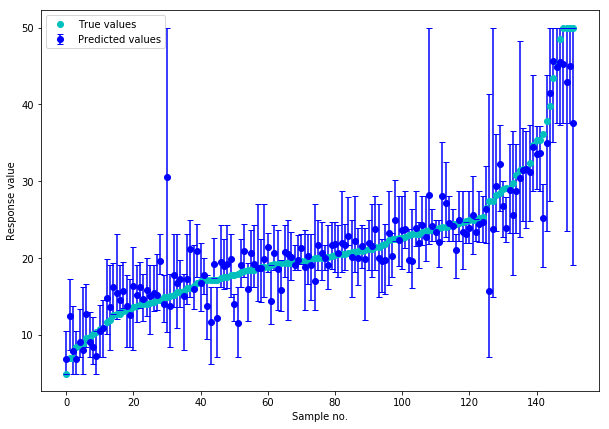

In [8]:
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, min_samples_leaf=1)
rf.fit(data_train, target_train)
prediction = rf.predict(data_eval)
lower_error_list, upper_error_list = compute_prediction_interval(rf, data_eval, percentile=90)

plot_eval_prediction_interval(target_eval, prediction, lower_error_list, upper_error_list)

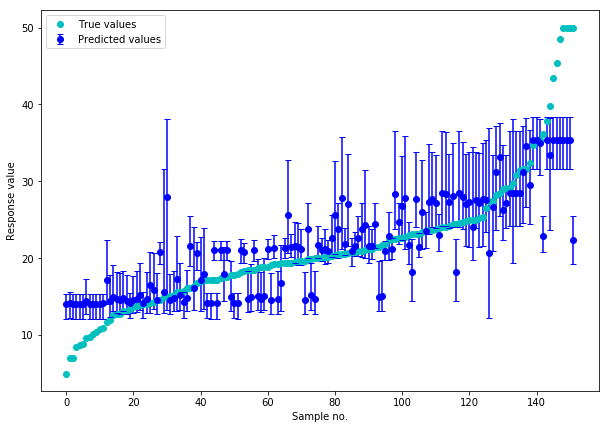

In [6]:
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, min_samples_leaf=40)
rf.fit(data_train, target_train)
prediction = rf.predict(data_eval)
lower_error_list, upper_error_list = compute_prediction_interval(rf, data_eval, percentile=90)

plot_eval_prediction_interval(target_eval, prediction, lower_error_list, upper_error_list)

### Même vérif qu'au dessus mais visuelle cette fois-ci

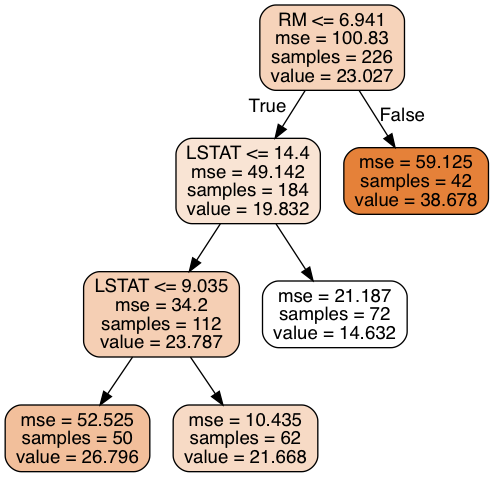

In [51]:
from IPython.display import Image
Image(filename='tree_mixed_leaf.png')

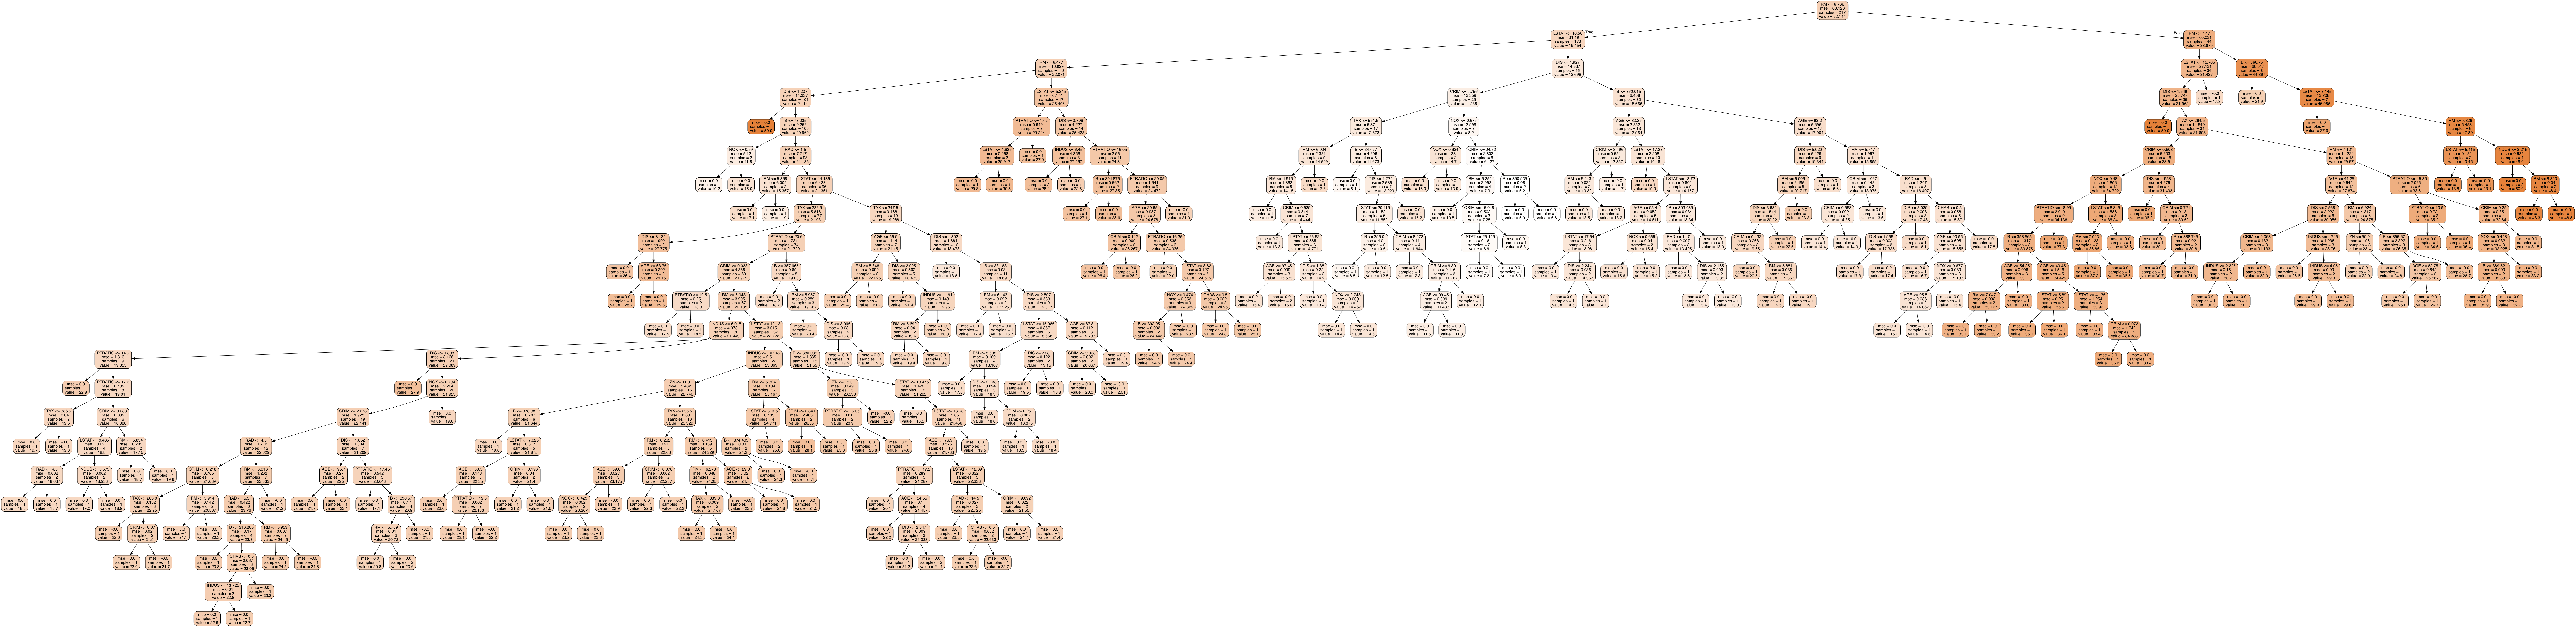

In [12]:
Image(filename='tree_pure_leaf.png')

### Visu pour voir l'arbre suivant le paramètre min_samples_leaf 

In [32]:
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, min_samples_leaf=1)
rf.fit(data_train, target_train)
prediction = rf.predict(data_eval)
decision_tree_prediction_matrix = [_compute_prediction_of_each_tree(rf.estimators_, data_eval[i]) for i in
                                   range(len(data_eval))]
lower_bound_prediction_list = [np.percentile(prediction_list, 5) for prediction_list in
                               decision_tree_prediction_matrix]
upper_bound_prediction_list = [np.percentile(prediction_list, 95) for prediction_list in
                               decision_tree_prediction_matrix]

In [39]:
mean_prediction_interval = (np.array(upper_bound_prediction_list) - lower_bound_prediction_list).mean()
mean_prediction_interval

9.381315789473682

### Intervalle de confiance du modèle

In [47]:
median_prediction = [np.median(prediction_list_trees) for prediction_list_trees in decision_tree_prediction_matrix ]

In [50]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(median_prediction, target_eval))
print(mean_squared_error(prediction, target_eval))

8.624720394736842
9.434124228289486


### Meilleur modèle avec la médiane

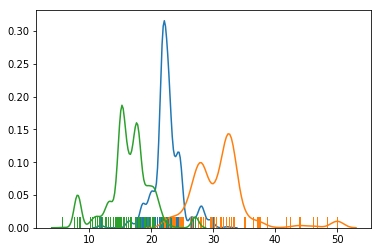

In [30]:
import seaborn as sns

sns.distplot(decision_tree_prediction_matrix[0], hist=False, rug=True)
sns.distplot(decision_tree_prediction_matrix[1], hist=False, rug=True)
sns.distplot(decision_tree_prediction_matrix[2], hist=False, rug=True);

### Quelques distrib de prédiction

In [167]:
import pandas as pd
ts = pd.read_csv('AirPassengers.csv')
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
ts = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
ts.tail()

#Passengers
Month                  
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

/anaconda3/envs/conda_py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/envs/conda_py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


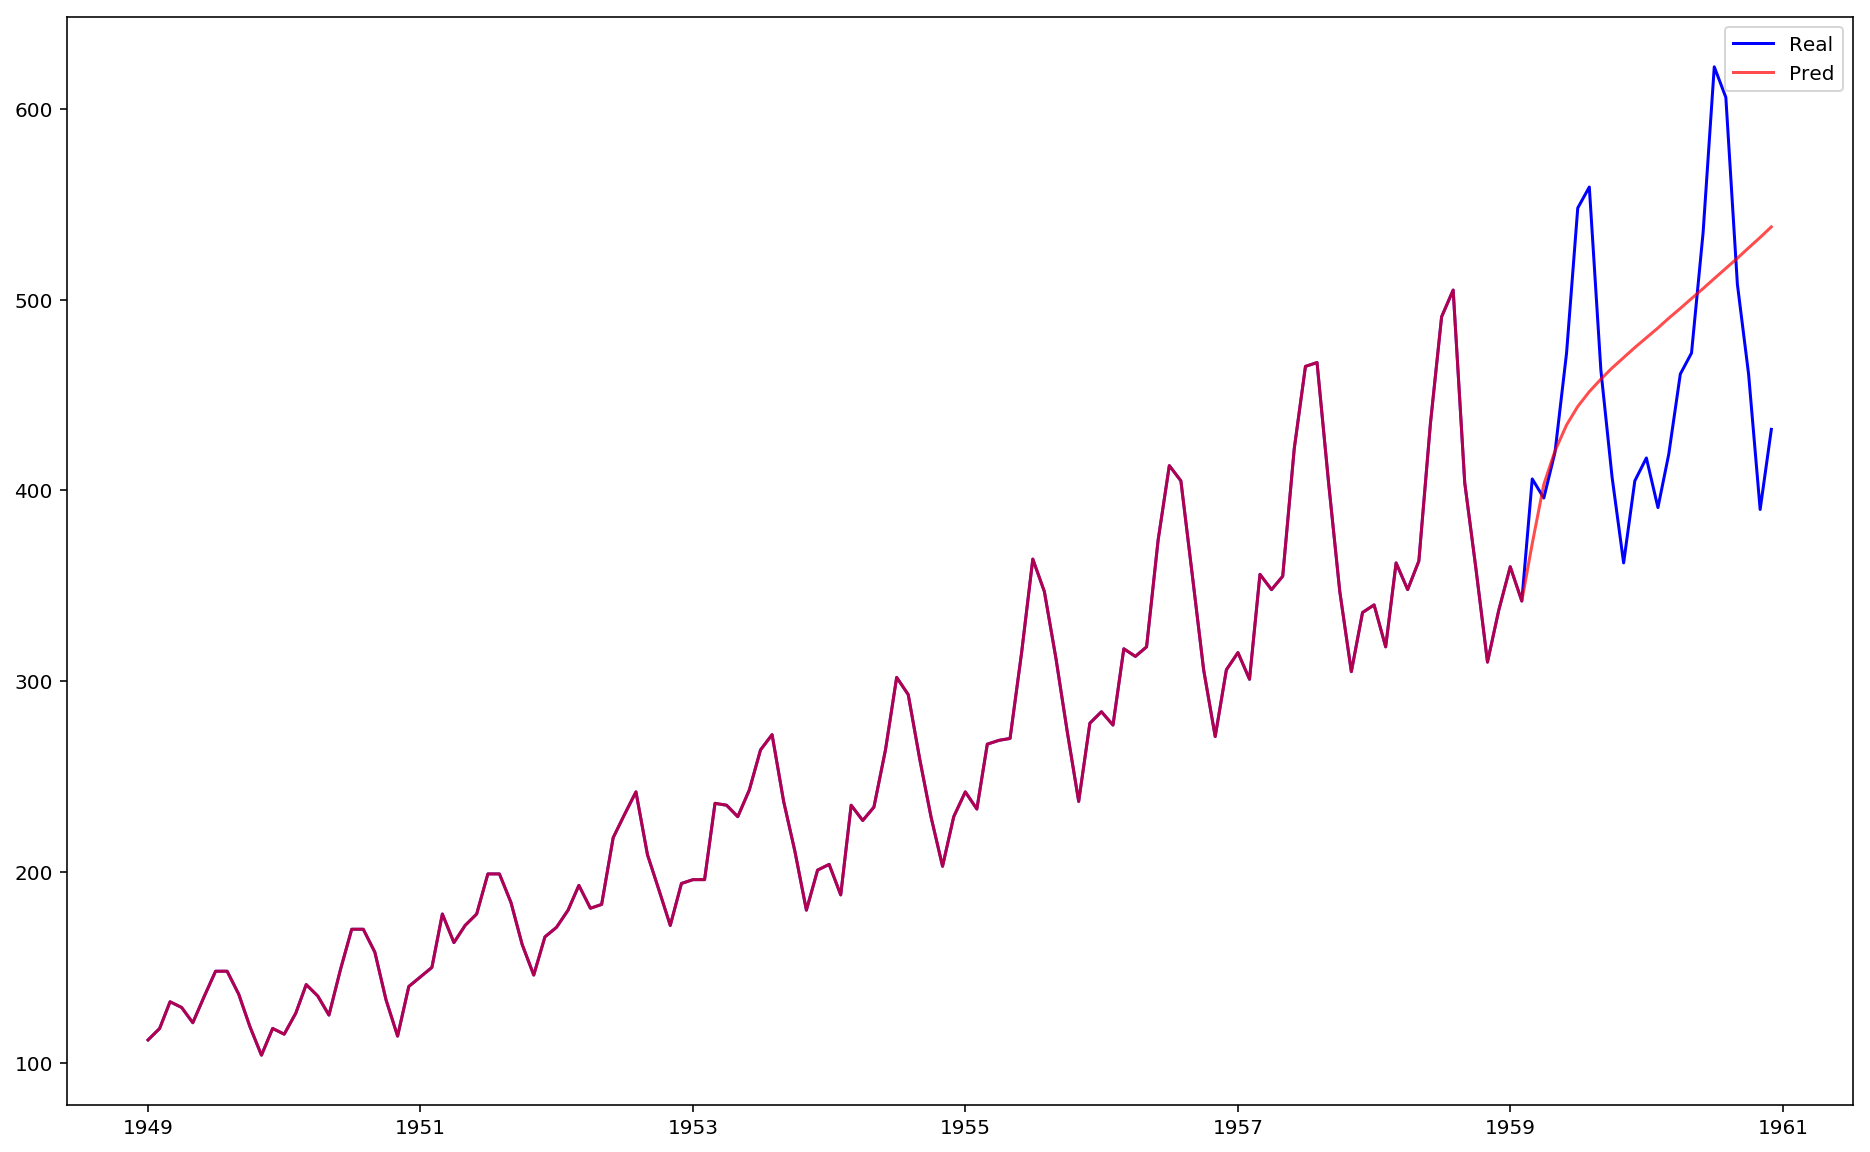

In [293]:
from statsmodels.tsa.arima_model import ARIMA

ts_log_train = np.log(ts.loc[ts.index <= '1959-02-01'])
predict_len = len(ts) - len(ts_log_train)

model = ARIMA(ts_log_train, order=(2, 1, 2))  
results_ARIMA = model.fit() 
predictions = results_ARIMA.forecast(steps=predict_len)
ts_pred = ts.copy()
ts_pred['#Passengers'][-predict_len:] = np.exp(predictions[0])

def plot_ts_pred(ts, ts_pred):
    plt.figure(figsize=(16,10))
    plt.plot(ts, color='blue',label='Real')
    plt.plot(ts_pred, color='red', label='Pred', alpha=0.7)
    plt.legend()
    plt.show()
plot_ts_pred(ts, ts_pred)

In [302]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(np.array(ts['#Passengers'][-predict_len:]), np.exp(predictions[0]))
print('RMSE: %f' % sqrt(mse))

RMSE: 74.458564


/anaconda3/envs/conda_py36/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


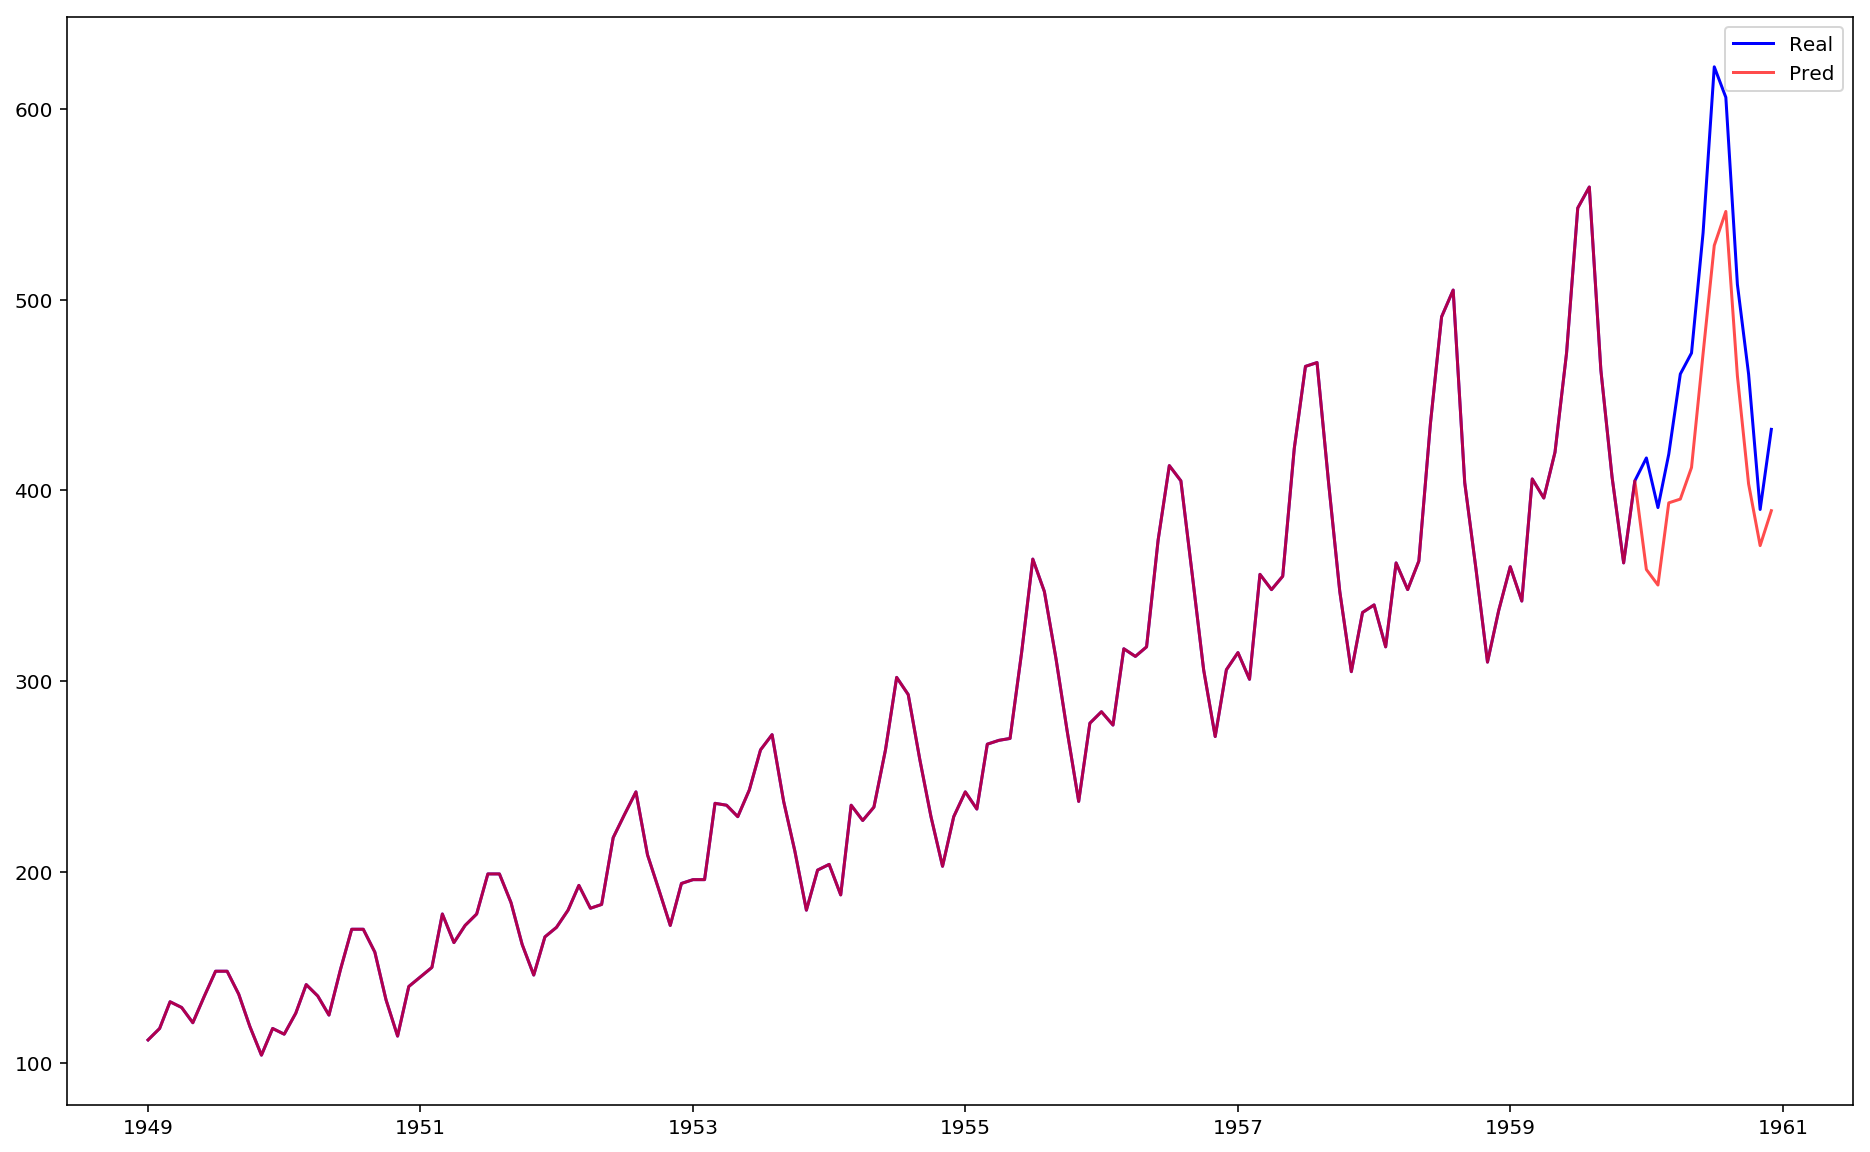

In [285]:
ts_rf = pd.read_csv('AirPassengers.csv')
ts_rf['Year'] = ts_rf['Month'].apply(lambda x: int(x.split('-')[0]))
ts_rf['Month'] = ts_rf['Month'].apply(lambda x: int(x.split('-')[1]))
ts_rf['#Passengers'] = np.log(ts_rf['#Passengers'])

ts_rf_train = ts_rf.loc[ts_rf.Year < 1960]
ts_rf_eval = ts_rf.loc[ts_rf.Year >= 1960]
y_ts_rf_train = ts_rf_train['#Passengers']
y_ts_rf_eval = ts_rf_eval['#Passengers']
ts_rf_train.drop('#Passengers', axis=1, inplace=True)
ts_rf_eval.drop('#Passengers', axis=1, inplace=True)
predict_len = len(ts) - len(ts_rf_train)

rf = RandomForestRegressor(n_estimators=1000)
rf.fit(ts_rf_train, y_ts_rf_train)

predictions = rf.predict(ts_rf_eval)
ts_pred = ts.copy()
ts_pred['#Passengers'][-predict_len:] = np.exp(predictions)

plot_ts_pred(ts, ts_pred)

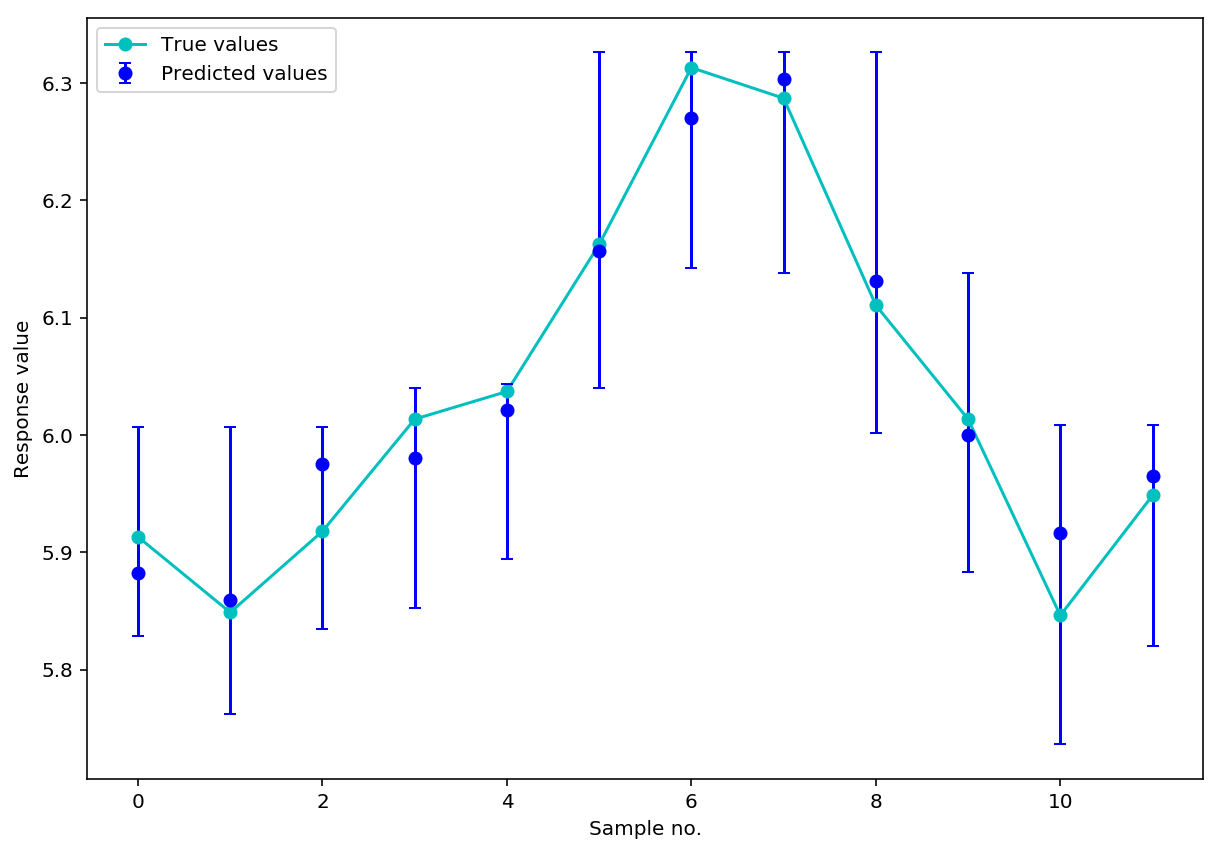

In [315]:
lower_error_list, upper_error_list = compute_prediction_interval(rf, np.array(ts_rf_eval))

def plot_eval_prediction_interval_wt_sort(target_eval, prediction, lower_error_list, upper_error_list, figsize=(10, 7)):
    x = range(len(prediction))
    y = target_eval
    sorted_predictions = prediction
    upper_error = np.array(upper_error_list) - sorted_predictions
    lower_error = sorted_predictions - np.array(lower_error_list)

    plt.figure(figsize=figsize)
    plt.plot(x, y, color='c', marker='o', markersize=6, label='True values')
    plt.errorbar(x, sorted_predictions, yerr=[lower_error, upper_error], fmt='bo', label='Predicted values', capsize=3)
    plt.ylabel('Response value')
    plt.xlabel('Sample no.')
    plt.legend(loc='upper left')
    plt.show()

plot_eval_prediction_interval_wt_sort(np.array(y_ts_rf_eval)-0.12, rf.predict(ts_rf_eval), lower_error_list, upper_error_list)

In [317]:
mse = mean_squared_error(np.array(y_ts_rf_eval)-0.12, rf.predict(ts_rf_eval))
print('RMSE: %f' % sqrt(mse))

RMSE: 0.033748


- get trend
- https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection
- https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b